In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import functools
import operator
import pickle
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

### Neural Network Class

In [16]:
"""
Contains the NN class, meant to be used as a single-hidden-layer dense neural network.
"""

import numpy as np


class NN:
    """
    This is meant to be used as a single-hidden-layer neural network.
    Uses a ReLU activation function after the first layer and a softmax output.
    
    Attributes:
        User inputted:
            input_length (int): the dimension of the input vector
            n_hidden_units (int): the number of units in the hidden layer
            n_outputs (int): in the XOR case, the number of classes, usually 2
            seed (int): the random seed to allow for experiment reproducibility

        Class managed:
            random_generator (RandomState): random number generator that inherits the user-inputted seed
            layer_dims (list): the input/output size of each layer, used to build the layers
            weights (list of dicts): the actual learnable weights of the network

    """
    def __init__(self, input_length, n_hidden_units, n_outputs, seed):

        self.input_length = input_length
        self.n_hidden_units = n_hidden_units
        self. n_outputs = n_outputs
        self.seed = seed

        self.random_generator = np.random.RandomState(seed)

        self.layer_dims = [self.input_length, self.n_hidden_units, self.n_outputs]
        self.weights = [dict() for _ in range(len(self.layer_dims) - 1)]
        for i in range(0, len(self.layer_dims) - 1):
            self.weights[i]['W'] = self._init_saxe(rows=self.layer_dims[i], cols=self.layer_dims[i + 1])
            self.weights[i]['b'] = self._init_saxe(rows=1, cols=self.layer_dims[i + 1])

    def _init_saxe(self, rows, cols):
        """Saxe weight initialization as based on Saxe et al. (2014) https://arxiv.org/pdf/1312.6120.pdf

        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            np.array of initialized weights
        """
        tensor = self.random_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

    def forward_pass(self, input, partial=False):
        """Computes a forward pass through the network.

        Args:
            input (np.array): input data
            partial (bool): used to pull out relevant information during the gradient calculation step

        Returns:
            np.array of predicted values [batch_size, n_outputs]
        """
        W_0 = self.weights[0]['W']
        b_0 = self.weights[0]['b']

        phi = np.maximum(0, np.dot(input, W_0) + b_0)

        W_1 = self.weights[1]['W']
        b_1 = self.weights[1]['b']

        # During gradient calculations, we only need the activated-output of the first layer
        if partial:
            return phi, np.dot(input, W_0) + b_0

        else:
            return np.dot(phi, W_1) + b_1

    @staticmethod
    def softmax(input):
        """Computes the softmax transformation from the output of the forward pass of the network. This is the version
        of softmax that is numerically stable. That is, it is not prone to either underflow or overflow.

        Args:
            input (np.array): 2d array [batch_size, n_outputs]
        Returns:

        """
        max_stablizer = np.max(input, axis=1).reshape((-1, 1))
        numerator = np.exp(input - max_stablizer)
        denominator = np.sum(numerator, axis=1).reshape((-1, 1))
        return (numerator / denominator).squeeze()

    @staticmethod
    def softmax_grad(y_pred, y_actual):
        """Handles the computation of the derivative of our softmax output.

        Args:
            y_pred (np.array, 2D): [batch_size, n_outputs]
            y_actual (np.array, 1D): [batch_size,]

        Returns:
            np.array, 2D - the gradient
        """
        y_pred[range(y_pred.shape[0]), y_actual] -= 1
        return y_pred / y_pred.shape[0]

    def get_gradient(self, input, y_pred, y_actual):
        """Look at that, the network can compute its own gradients!

        Args:
            input (np.array): our training examples [batch_size, n_outputs]
            y_pred (np.array): the predicted values (POST SOFTMAX) [batch_size, n_outputs)
            y_actual (np.array): the ground-truth labels [batch_size,]

        Returns:
            a list of dictionaries with the same structure as the self.weights attribute
        """
        # For an explanation of what is going on, please see the "Derivation of the backprop algorithm" section of
        # the README.
        relu_output, non_activation = self.forward_pass(input=input, partial=True)

        dL_dsoftmax = self.softmax_grad(y_pred=y_pred, y_actual=y_actual)

        grad = [dict() for i in range(len(self.weights))]

        dL_db_1 = np.sum(dL_dsoftmax, axis=0, keepdims=True) / input.shape[0]

        dL_dW_1 = np.dot(relu_output.T, dL_dsoftmax) / input.shape[0]

        # gradient in layer ahead * weights in layer ahead.T * deriv of ReLU
        dx = (non_activation > 0).astype(float)
        dL_db_0 = np.sum(np.dot(dL_dsoftmax, self.weights[1]['W'].T) * dx, axis=0, keepdims=True)

        # gradient in layer ahead * input data
        dL_dW_0 = np.dot(input.T, np.dot(dL_dsoftmax, self.weights[1]['W'].T) * dx)

        grad[0]['W'] = dL_dW_0
        grad[0]['b'] = dL_db_0
        grad[1]['W'] = dL_dW_1
        grad[1]['b'] = dL_db_1

        return grad


### Adam Optimizer Class

In [17]:
"""
The Adam algorithm improves the SGD update with two concepts: adaptive vector stepsizes and momentum.
It keeps running estimates of the mean and second moment of the updates, denoted by:

m_t = B_m * m_t-1 + (1 - B_m)g1_t
v_t = B_v * v_t-1 + (1 - B_v)g^2_t

B_m, B_v are fixed parameters
The g's are the gradients
Given that m, v are init to 0, they are biased towards 0. To get unbiased estimates,
we use...
\hat{m_t} = m_t / (1 - B^t_m)
\hat{v_t} = v_t / (1 - B^t_v)

NOTE: in the above calculations, the beta parameters are raised to the power of the timestep

Using the above, the weight updates are ultimately...
w_t = w_t-1 + (alpha / sqrt(\hat{v_t} + epsilon)) * \hat{m_t}
"""
class ADAM:
    """
    This is a bare-bones implementation of the ADAM optimizer based on Kingma, Ba (2014) https://arxiv.org/abs/1412.6980

    Attributes:
        layer_dims (list): should be directly passed from the NN.layer_dims attribute to ensure compatibility
        alpha (float): the step-size (learning rate)
        beta_m (float): the coefficient for the "momentum" hyperparameter
        beta_v (float): the coefficient for the "velocity" hyperparameter
        epsilon (float): a very small value, meant to be a stabilizer for when v_hat may be 0
    """
    def __init__(self, layer_dims, alpha, beta_m, beta_v, epsilon):
        self.layer_dims = layer_dims
        self.alpha = alpha
        self.beta_m = beta_m
        self.beta_v = beta_v
        self.epsilon = epsilon

        self.m = [dict() for _ in range(len(self.layer_dims) - 1)]
        self.v = [dict() for _ in range(len(self.layer_dims) - 1)]

        for i in range(len(self.layer_dims) - 1):
            self.m[i]['W'] = np.zeros((self.layer_dims[i], self.layer_dims[i + 1]))
            self.m[i]['b'] = np.zeros((1, self.layer_dims[i + 1]))
            self.v[i]['W'] = np.zeros((self.layer_dims[i], self.layer_dims[i + 1]))
            self.v[i]['b'] = np.zeros((1, self.layer_dims[i + 1]))

        # Instead of requiring a global tracker of the step, we can keep track of the product
        self.beta_m_exp = self.beta_m
        self.beta_v_exp = self.beta_v

    def update_weights(self, weights, gradient):
        """The completion of the backpropagation algorithm, applying both the momentum and the gradient to the weights.
        In addition, this method handles the updating of all hyperparameters.

        Args:
            weights (array of dicts): the weight dicts from the network class, use a DIRECT REFERENCE! NOT A COPY!
            gradient (array of dicts): the array of dicts returned by the NN.get_gradient() method

        Returns:
            None. the network's weights are mutable, so this method will actually be mutating the weights of the
            network directly, assuming a direct reference to them was passed to the "weights" argument
        """

        for i in range(len(weights)):
            for param in weights[i].keys():
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * gradient[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * gradient[i][param] ** 2

                m_hat = self.m[i][param] / (1 - self.beta_m_exp)
                v_hat = self.v[i][param] / (1 - self.beta_v_exp)

                weights[i][param] = weights[i][param] - self.alpha / (np.sqrt(v_hat) + self.epsilon) * m_hat

        self.beta_m_exp *= self.beta_m
        self.beta_v_exp *= self.beta_v


### Cross Entropy Loss Function

In [18]:
def cross_entropy_loss(y_pred, y_actual):
    """Computes the cross-entropy loss for a categorization problem

    Args:
        y_pred: the output of the network (in post-softmax form)
        y_actual: NOT one-hot encoded

    Returns:
        a scalar, the loss
    """
    log_likelihood = -np.log(y_pred[range(y_actual.shape[0]), y_actual])
    return np.sum(log_likelihood) / y_actual.shape[0]


### Mini-batching class

In [19]:
class MiniBatcher:
    """A class meant to handle to batching of a given dataset

    Randomly samples the dataset via an index-yielder
    Simply shuffling the data adds complications because we need our labels to always correspond to our inputs.
    Instead, the class holds an attribute that is shuffled independently of the data itself. This attribute is then
    sliced to size batch_size which is then used to index the given data and labels.

    At the end of each epoch, when the MiniBatcher is out of data, it will return (False, False)
    To reset the batching, simply call MiniBatcher.new_epoch(). This method will auto shuffle the indexes once again
    and you will be able to pull out another batch.

    Attributes:
        User inputted:
            data (array): our data samples
            labels (array): our labels
            batch_size (int): the size of our minibatches
            seed (int): the random seed to allow for experiment reproducibility

        Class managed:
            random_generator (RandomState): random number generator that inherits the user-inputted seed
            data_batching_order (array): an array of numbers 0-len(data)
            __mb_idx__ (generator): a generator that will yield an array of indexes
    """
    def __init__(self, data, labels, batch_size, seed):
        self.data = deepcopy(data)
        self.labels = deepcopy(labels)
        self.batch_size = batch_size
        self.seed = seed
        
        self.random_generator = np.random.RandomState(seed)
        
        # This minibatch class works off of a generator that yields an array of indexes
        # This works for us by slicing the data_batching_order array
        # (1) Init array with every idx from [0,len(data)]
        # (2) Shuffle said array
        # (3) Init our generator
        self.data_batching_order = np.array([x for x in range(data.shape[0])]) 
        self._data_shuffle()
        self.__mb_idx__ = self._idx_yielder()
        
    def fetch_minibatch(self):
        """
        If this method returns [False, False], then we know that our data is out and it's time to start a new epoch!
        """
        # As our generator can run out we need a try/except 
        try:
            idxs = self.__mb_idx__.__next__()
            if len(idxs) == 0:
                return False, False
            else:
                return self.data[idxs], self.labels[idxs]
        except:
            return False, False
            
    def _data_shuffle(self):
        """Simply shuffles the data_batching_order attribute in-place"""
        # This performs the shuffle in place, no need to return anything
        self.random_generator.shuffle(self.data_batching_order)
        
    def _idx_yielder(self):
        """Returns a generator of a sliding window over self.data_batching_order"""
        lag_idx = 0
        lead_idx = 0 + self.batch_size
        
        while lag_idx <= self.data.shape[0]:
            yield self.data_batching_order[lag_idx: lead_idx]
            lag_idx += self.batch_size
            lead_idx += self.batch_size
            
    def new_epoch(self):
        """At the beginning of every new epoch, call this method to reset the generator. Will be different than the last."""
        self._data_shuffle()
        self.__mb_idx__ = self._idx_yielder()
            

### Classification profiling class

In [20]:
class ClassificationProfiler:
    """
    At each step, please feed an array of predictions and actuals to this class as AccuracyProfiler.y_pred.append(...)
    Please ensure that the data you feed here is in the form of a LIST!
    
    Metrics:
        (i) Accuracy
        (ii) Precision
        (iii) Recall
        (iv) F1-Score
    Altitude:
        (i) Overall dataset
        (ii) Class-by-class
        
    The self.info attribute is structured as:
    {
        epoch_num: {
            'Class': {
                'Precision': {
                    1: float
                    2: float
                    ...
                }
                'Recall': {
                    1: float
                    2: float
                    ...
                }
                'F1': {
                    1: float
                    2: float
                    ...
                }
            }
            'Overall': {
                'Accuracy': float
            }
        }
    }
    """
    def __init__(self, classes):  
        self.classes = classes
        
        self.epoch = 0
        self.info = defaultdict()
        self.y_pred = list()
        self.y_actual = list()
        
        self.info[self.epoch] = defaultdict()
        self.info[self.epoch]['Overall'] = defaultdict()
        self.info[self.epoch]['Class'] = defaultdict()
        
    def _increment_epoch(self):
        """Run in-between calls to increment the epoch"""
        self.epoch += 1
        self.info[self.epoch] = defaultdict()
        self.info[self.epoch]['Overall'] = defaultdict()
        self.info[self.epoch]['Class'] = defaultdict()
        self.y_pred = list()
        self.y_actual = list()
    
    def update_stats(self):
        """"""
        # Need to unpack our data
        self._unpack_data()
        
        self._calculate_accuracy()
        self._calculate_precision_recall()
        self._calculate_f1score()
        
        # Last thing to do now is increment the epoch for the next updating set
        self._increment_epoch()

    def _unpack_data(self):
        """"""
        self.y_actual = functools.reduce(operator.concat, self.y_actual, [])
        self.y_pred = functools.reduce(operator.concat, self.y_pred, [])
    
    def _calculate_accuracy(self):
        """"""
        self.info[self.epoch]['Overall']['Accuracy'] = np.sum([self.y_pred[i] == self.y_actual[i] for i in range(len(self.y_pred))]) / len(self.y_pred)
        
    def _calculate_precision_recall(self):
        """"""
        # Need to init these metrics
        self.info[self.epoch]['Class']['Precision'] = defaultdict()
        self.info[self.epoch]['Class']['Recall'] = defaultdict()   

        for c in self.classes:
            t_idxs = [i for i, x in enumerate(self.y_pred) if x == c]
            f_idxs = [i for i, x in enumerate(self.y_pred) if x != c]
            
            # First doing the true's
            y_pred_subset = [self.y_pred[x] for x in t_idxs]
            y_actual_subset = [self.y_actual[x] for x in t_idxs]
            tp = np.sum([y_pred_subset[i] == y_actual_subset[i] for i in range(len(y_pred_subset))])
            
            self.info[self.epoch]['Class']['Precision'][c] = tp / len(t_idxs)
            
            # On to the false's
            # For this, we can get the false negatives by first subsetting our y_actual vector to every index where we predicted
            # the true class was NOT c, then getting a count for how many times it actually WAS c
            y_actual_subset = [self.y_actual[x] for x in f_idxs]
            fn = y_actual_subset.count(c)
            
            self.info[self.epoch]['Class']['Recall'][c] = tp / (tp + fn)
    
    def _calculate_f1score(self):
        """"""
        self.info[self.epoch]['Class']['F1'] = defaultdict()
        
        for c in self.classes:
            numerator = self.info[self.epoch]['Class']['Precision'][c] * self.info[self.epoch]['Class']['Recall'][c]
            denominator = self.info[self.epoch]['Class']['Precision'][c] + self.info[self.epoch]['Class']['Recall'][c]
            self.info[self.epoch]['Class']['F1'][c] = 2 * numerator / denominator
    

# Data

In [14]:
# (1) Our training loop is not meant to work with 1-hot-encoded targets, so all we need to do is turn them into numbers
# (2) Write mini-batch function

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
# Need to normalize our X data and converting our y data into int
X = np.array([x / 255.0 for x in X])
y = np.array([int(x) for x in y])

In [5]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

In [6]:
[1, 2, 3, 3].count(3)

2

In [9]:
for c in np.unique(y_train):
    print(f'{c}: {list(y_train).count(c) / len(y_train)}')

0: 0.09871666666666666
1: 0.11236666666666667
2: 0.0993
3: 0.10218333333333333
4: 0.09736666666666667
5: 0.09035
6: 0.09863333333333334
7: 0.10441666666666667
8: 0.09751666666666667
9: 0.09915


In [11]:
for c in np.unique(y_train):
    print(f'{c}: {list(y_test).count(c) / len(y_test)}')

0: 0.098
1: 0.1135
2: 0.1032
3: 0.101
4: 0.0982
5: 0.0892
6: 0.0958
7: 0.1028
8: 0.0974
9: 0.1009


## Experiment 1

In [128]:
lrs = [0.00001, 0.0001, 0.001, 0.01, 0.1]
n_seed_trials = 5

In [129]:
results = defaultdict()

for lr in tqdm(lrs):
    results[lr] = defaultdict()
    
    for _ in tqdm(range(n_seed_trials)):
        new_seed = np.random.randint(1, 10000)
        
        # Reset our classes with the new number of hidden units as well as the newly generated seed
        nn = NN(input_length=X.shape[1], n_hidden_units=100, n_outputs=10, seed=new_seed)
        adam = ADAM(layer_dims=nn.layer_dims, alpha=lr, beta_m=0.99, beta_v=0.999, epsilon=0.00001)
        mb_train = MiniBatcher(data=X_train, labels=y_train, batch_size=64, seed=new_seed)
        mb_test = MiniBatcher(data=X_test, labels=y_test, batch_size=64, seed=new_seed)
        train_profiler = ClassificationProfiler(classes=np.unique(y_train))
        test_profiler = ClassificationProfiler(classes=np.unique(y_train))

        # Then we train
        EPOCHS = 100

        train_loss_historical = list()
        test_loss_historical = list()

        epoch_counter = 0

        while epoch_counter < EPOCHS:
            X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            # If we've run out of training data in our training minibatcher, we can start on the testing loop
            # as well as incrementing our profiler
            if isinstance(X_mb_train, bool):
                X_mb_test, y_mb_test = mb_test.fetch_minibatch()
                train_profiler.update_stats()

                while not isinstance(X_mb_test, bool):
                    fp_output_test = nn.forward_pass(input=X_mb_test)
                    sm_output_test = nn.softmax(input=fp_output_test)
                    test_loss = cross_entropy_loss(y_pred=sm_output_test, y_actual=y_mb_test)
                    test_loss_historical.append(test_loss)

                    test_profiler.y_pred.append(np.argmax(sm_output_test, axis=1).tolist())
                    test_profiler.y_actual.append(y_mb_test.tolist())

                    X_mb_test, y_mb_test = mb_test.fetch_minibatch()

                # Here in the control-flow, we have exhausted our test-minibatcher 
                epoch_counter += 1
                mb_train.new_epoch()
                mb_test.new_epoch()

                test_profiler.update_stats()

                X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            fp_output = nn.forward_pass(input=X_mb_train)
            sm_output = nn.softmax(input=fp_output)
            train_loss = cross_entropy_loss(y_pred=sm_output, y_actual=y_mb_train)
            train_loss_historical.append(train_loss)

            # It's important that we perform this append before the gradient is calculated
            # Something is accidentally mutable... 
            train_profiler.y_pred.append(np.argmax(sm_output, axis=1).tolist())
            train_profiler.y_actual.append(y_mb_train.tolist())

            grad = nn.get_gradient(input=X_mb_train, y_pred=sm_output, y_actual=y_mb_train)
            adam.update_weights(weights=nn.weights, gradient=grad)

        # Recording the results
        results[lr][new_seed] = defaultdict()
        train_epoch_acc = list()
        test_epoch_acc = list()

        for e in range(EPOCHS):
            train_epoch_acc.append(train_profiler.info[e]['Overall']['Accuracy'])
            test_epoch_acc.append(test_profiler.info[e]['Overall']['Accuracy'])

        results[lr][new_seed]['train'] = train_epoch_acc
        results[lr][new_seed]['test'] = test_epoch_acc

  0%|          | 0/5 [00:00<?, ?it/s]/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()

100%|██████████| 5/5 [2:35:50<00:00, 1870.14s/it]


In [131]:
with open('./results/experiment_1.data', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
results = []
with (open("./results/experiment_1.data", "rb")) as openfile:
    while True:
        try:
            results.append(pickle.load(openfile))
        except EOFError:
            break

In [26]:
results = results[0]

In [27]:
seeds_1 = results[1e-05].keys()
seeds_2 = results[0.0001].keys()
seeds_3 = results[0.001].keys()
seeds_4 = results[0.01].keys()
seeds_5 = results[0.1].keys()

In [28]:
print(seeds_1)
print(seeds_2)
print(seeds_3)
print(seeds_4)
print(seeds_5)

dict_keys([706, 9767, 8192, 5374, 6530])
dict_keys([3423, 6488, 5346, 1379, 1216])
dict_keys([5893, 7380, 512, 8782, 3610])
dict_keys([3694, 1406, 5642, 5188, 9519])
dict_keys([400, 8778, 7814, 7766, 515])


In [29]:
train_1 = np.array(([results[1e-05][x]['train'] for x in seeds_1]))
test_1 = np.array(([results[1e-05][x]['test'] for x in seeds_1]))

train_2 = np.array(([results[0.0001][x]['train'] for x in seeds_2]))
test_2 = np.array(([results[0.0001][x]['test'] for x in seeds_2]))

train_3 = np.array(([results[0.001][x]['train'] for x in seeds_3]))
test_3 = np.array(([results[0.001][x]['test'] for x in seeds_3]))

train_4 = np.array(([results[0.01][x]['train'] for x in seeds_4]))
test_4 = np.array(([results[0.01][x]['test'] for x in seeds_4]))

train_5 = np.array(([results[0.1][x]['train'] for x in seeds_5]))
test_5 = np.array(([results[0.1][x]['test'] for x in seeds_5]))

In [31]:
np.min(train_1, axis=0)

array([0.32841667, 0.69401667, 0.80146667, 0.83223333, 0.8495    ,
       0.86268333, 0.87173333, 0.879     , 0.88503333, 0.88931667,
       0.89326667, 0.89666667, 0.89891667, 0.9016    , 0.90388333,
       0.90563333, 0.9075    , 0.90895   , 0.91035   , 0.91175   ,
       0.9127    , 0.91378333, 0.91451667, 0.91578333, 0.91686667,
       0.91773333, 0.91876667, 0.91936667, 0.92065   , 0.92141667,
       0.92191667, 0.9227    , 0.9235    , 0.9244    , 0.92486667,
       0.92571667, 0.92626667, 0.9272    , 0.92775   , 0.92838333,
       0.92903333, 0.92971667, 0.93013333, 0.93068333, 0.93143333,
       0.93223333, 0.93245   , 0.93303333, 0.93343333, 0.93418333,
       0.93483333, 0.93518333, 0.93616667, 0.93646667, 0.93728333,
       0.9375    , 0.93826667, 0.93875   , 0.93906667, 0.93936667,
       0.93993333, 0.9403    , 0.94071667, 0.9413    , 0.94161667,
       0.94203333, 0.94238333, 0.94243333, 0.94293333, 0.94326667,
       0.94361667, 0.94426667, 0.94445   , 0.94486667, 0.94518

In [32]:
np.max(train_1, axis=0)

array([0.39846667, 0.74753333, 0.82063333, 0.84426667, 0.85703333,
       0.86796667, 0.877     , 0.88336667, 0.88821667, 0.8924    ,
       0.89618333, 0.89898333, 0.90153333, 0.90406667, 0.906     ,
       0.90763333, 0.90956667, 0.91078333, 0.91258333, 0.91398333,
       0.91511667, 0.91626667, 0.91736667, 0.91853333, 0.9195    ,
       0.92033333, 0.92123333, 0.92238333, 0.92301667, 0.92393333,
       0.92495   , 0.92533333, 0.92641667, 0.92695   , 0.92783333,
       0.9282    , 0.92903333, 0.92985   , 0.93026667, 0.93125   ,
       0.93163333, 0.93206667, 0.93266667, 0.93338333, 0.9342    ,
       0.9347    , 0.9353    , 0.93578333, 0.93623333, 0.93686667,
       0.93765   , 0.93808333, 0.93858333, 0.93921667, 0.9396    ,
       0.93993333, 0.94073333, 0.94106667, 0.94148333, 0.94211667,
       0.94248333, 0.94293333, 0.94333333, 0.9439    , 0.9439    ,
       0.94455   , 0.94485   , 0.94525   , 0.94565   , 0.9458    ,
       0.94636667, 0.94666667, 0.94718333, 0.94755   , 0.94771

NameError: name 'lrs' is not defined

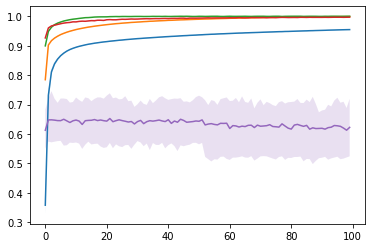

In [33]:
plt.plot(np.mean(train_1, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_1, axis=0), np.max(train_1, axis=0), alpha=0.2)

plt.plot(np.mean(train_2, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_2, axis=0), np.max(train_2, axis=0), alpha=0.2)

plt.plot(np.mean(train_3, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_3, axis=0), np.max(train_3, axis=0), alpha=0.2)

plt.plot(np.mean(train_4, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_4, axis=0), np.max(train_4, axis=0), alpha=0.2)

plt.plot(np.mean(train_5, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_5, axis=0), np.max(train_5, axis=0), alpha=0.2)

plt.legend([str(x) for x in lrs])
plt.title('Accuracy on Training Set (Experiment 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig('./results/experiment_1_training.png', dpi=400)

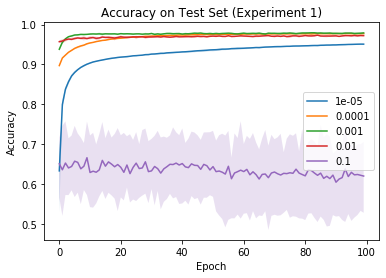

In [140]:
plt.plot(np.mean(test_1, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_1, axis=0), np.max(test_1, axis=0), alpha=0.2)

plt.plot(np.mean(test_2, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_2, axis=0), np.max(test_2, axis=0), alpha=0.2)

plt.plot(np.mean(test_3, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_3, axis=0), np.max(test_3, axis=0), alpha=0.2)

plt.plot(np.mean(test_4, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_4, axis=0), np.max(test_4, axis=0), alpha=0.2)

plt.plot(np.mean(test_5, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_5, axis=0), np.max(test_5, axis=0), alpha=0.2)

plt.legend([str(x) for x in lrs])
plt.title('Accuracy on Test Set (Experiment 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('./results/experiment_1_test.png', dpi=400)

## Experiment 2

In [108]:
batch_sizes = [16, 32, 64, 128, 256]
n_seed_trials = 5

In [109]:
results = defaultdict()

for bs in tqdm(batch_sizes):
    results[bs] = defaultdict()
    
    for _ in tqdm(range(n_seed_trials)):
        new_seed = np.random.randint(1, 10000)
        
        # Reset our classes with the new number of hidden units as well as the newly generated seed
        nn = NN(input_length=X.shape[1], n_hidden_units=100, n_outputs=10, seed=new_seed)
        adam = ADAM(layer_dims=nn.layer_dims, alpha=0.01, beta_m=0.99, beta_v=0.999, epsilon=0.00001)
        mb_train = MiniBatcher(data=X_train, labels=y_train, batch_size=bs, seed=new_seed)
        mb_test = MiniBatcher(data=X_test, labels=y_test, batch_size=bs, seed=new_seed)
        train_profiler = ClassificationProfiler(classes=np.unique(y_train))
        test_profiler = ClassificationProfiler(classes=np.unique(y_train))

        # Then we train
        EPOCHS = 100

        train_loss_historical = list()
        test_loss_historical = list()

        epoch_counter = 0

        while epoch_counter < EPOCHS:
            X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            # If we've run out of training data in our training minibatcher, we can start on the testing loop
            # as well as incrementing our profiler
            if isinstance(X_mb_train, bool):
                X_mb_test, y_mb_test = mb_test.fetch_minibatch()
                train_profiler.update_stats()

                while not isinstance(X_mb_test, bool):
                    fp_output_test = nn.forward_pass(input=X_mb_test)
                    sm_output_test = nn.softmax(input=fp_output_test)
                    test_loss = cross_entropy_loss(y_pred=sm_output_test, y_actual=y_mb_test)
                    test_loss_historical.append(test_loss)

                    test_profiler.y_pred.append(np.argmax(sm_output_test, axis=1).tolist())
                    test_profiler.y_actual.append(y_mb_test.tolist())

                    X_mb_test, y_mb_test = mb_test.fetch_minibatch()

                # Here in the control-flow, we have exhausted our test-minibatcher 
                epoch_counter += 1
                mb_train.new_epoch()
                mb_test.new_epoch()

                test_profiler.update_stats()

                X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            fp_output = nn.forward_pass(input=X_mb_train)
            sm_output = nn.softmax(input=fp_output)
            train_loss = cross_entropy_loss(y_pred=sm_output, y_actual=y_mb_train)
            train_loss_historical.append(train_loss)

            # It's important that we perform this append before the gradient is calculated
            # Something is accidentally mutable... 
            train_profiler.y_pred.append(np.argmax(sm_output, axis=1).tolist())
            train_profiler.y_actual.append(y_mb_train.tolist())

            grad = nn.get_gradient(input=X_mb_train, y_pred=sm_output, y_actual=y_mb_train)
            adam.update_weights(weights=nn.weights, gradient=grad)

        # Recording the results
        results[bs][new_seed] = defaultdict()
        train_epoch_acc = list()
        test_epoch_acc = list()

        for e in range(EPOCHS):
            train_epoch_acc.append(train_profiler.info[e]['Overall']['Accuracy'])
            test_epoch_acc.append(test_profiler.info[e]['Overall']['Accuracy'])

        results[bs][new_seed]['train'] = train_epoch_acc
        results[bs][new_seed]['test'] = test_epoch_acc

 60%|██████    | 3/5 [28:30<18:58, 569.02s/it]/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()

100%|██████████| 5/5 [3:09:29<00:00, 2273.81s/it]


In [151]:
np.mean([214.93 ,217.51 , 219.93,219.47, 218.39])

218.046

In [110]:
with open('./results/experiment_2.data', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
seeds_16 = results[16].keys()
seeds_32 = results[32].keys()
seeds_64 = results[64].keys()
seeds_128 = results[128].keys()
seeds_256 = results[256].keys()

In [113]:
train_16 = np.array(([results[16][x]['train'] for x in seeds_16]))
test_16 = np.array(([results[16][x]['test'] for x in seeds_16]))

train_32 = np.array(([results[32][x]['train'] for x in seeds_32]))
test_32 = np.array(([results[32][x]['test'] for x in seeds_32]))

train_64 = np.array(([results[64][x]['train'] for x in seeds_64]))
test_64 = np.array(([results[64][x]['test'] for x in seeds_64]))

train_128 = np.array(([results[128][x]['train'] for x in seeds_128]))
test_128 = np.array(([results[128][x]['test'] for x in seeds_128]))

train_256 = np.array(([results[256][x]['train'] for x in seeds_256]))
test_256 = np.array(([results[256][x]['test'] for x in seeds_256]))

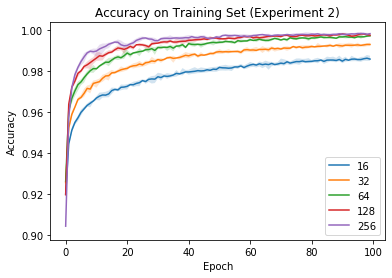

In [116]:
plt.plot(np.mean(train_16, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_16, axis=0), np.max(train_16, axis=0), alpha=0.2)

plt.plot(np.mean(train_32, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_32, axis=0), np.max(train_32, axis=0), alpha=0.2)

plt.plot(np.mean(train_64, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_64, axis=0), np.max(train_64, axis=0), alpha=0.2)

plt.plot(np.mean(train_128, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_128, axis=0), np.max(train_128, axis=0), alpha=0.2)

plt.plot(np.mean(train_256, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_256, axis=0), np.max(train_256, axis=0), alpha=0.2)

plt.legend([str(x) for x in batch_sizes])
plt.title('Accuracy on Training Set (Experiment 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('./results/experiment_2_training.png', dpi=400)

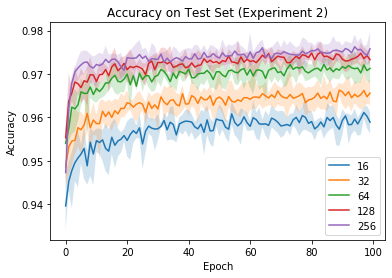

In [117]:
plt.plot(np.mean(test_16, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_16, axis=0), np.max(test_16, axis=0), alpha=0.2)

plt.plot(np.mean(test_32, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_32, axis=0), np.max(test_32, axis=0), alpha=0.2)

plt.plot(np.mean(test_64, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_64, axis=0), np.max(test_64, axis=0), alpha=0.2)

plt.plot(np.mean(test_128, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_128, axis=0), np.max(test_128, axis=0), alpha=0.2)

plt.plot(np.mean(test_256, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_256, axis=0), np.max(test_256, axis=0), alpha=0.2)

plt.legend([str(x) for x in batch_sizes])
plt.title('Accuracy on Test Set (Experiment 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('./results/experiment_2_test.png', dpi=400)

## Experiment 3

In [45]:
# Performing a brute search on the number of hidden nodes...
node_experiments = [10, 25, 50, 100, 200]
n_seed_trials = 5

In [52]:
results = defaultdict()

for ne in tqdm(node_experiments):
    results[ne] = defaultdict()
    
    for _ in tqdm(range(n_seed_trials)):
        new_seed = np.random.randint(1, 10000)
        
        # Reset our classes with the new number of hidden units as well as the newly generated seed
        nn = NN(input_length=X.shape[1], n_hidden_units=ne, n_outputs=10, seed=new_seed)
        adam = ADAM(layer_dims=nn.layer_dims, alpha=0.01, beta_m=0.99, beta_v=0.999, epsilon=0.00001)
        mb_train = MiniBatcher(data=X_train, labels=y_train, batch_size=64, seed=new_seed)
        mb_test = MiniBatcher(data=X_test, labels=y_test, batch_size=64, seed=new_seed)
        train_profiler = ClassificationProfiler(classes=np.unique(y_train))
        test_profiler = ClassificationProfiler(classes=np.unique(y_train))

        # Then we train
        EPOCHS = 100

        train_loss_historical = list()
        test_loss_historical = list()

        epoch_counter = 0

        while epoch_counter < EPOCHS:
            X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            # If we've run out of training data in our training minibatcher, we can start on the testing loop
            # as well as incrementing our profiler
            if isinstance(X_mb_train, bool):
                X_mb_test, y_mb_test = mb_test.fetch_minibatch()
                train_profiler.update_stats()

                while not isinstance(X_mb_test, bool):
                    fp_output_test = nn.forward_pass(input=X_mb_test)
                    sm_output_test = nn.softmax(input=fp_output_test)
                    test_loss = cross_entropy_loss(y_pred=sm_output_test, y_actual=y_mb_test)
                    test_loss_historical.append(test_loss)

                    test_profiler.y_pred.append(np.argmax(sm_output_test, axis=1).tolist())
                    test_profiler.y_actual.append(y_mb_test.tolist())

                    X_mb_test, y_mb_test = mb_test.fetch_minibatch()

                # Here in the control-flow, we have exhausted our test-minibatcher 
                epoch_counter += 1
                mb_train.new_epoch()
                mb_test.new_epoch()

                test_profiler.update_stats()

                X_mb_train, y_mb_train = mb_train.fetch_minibatch()

            fp_output = nn.forward_pass(input=X_mb_train)
            sm_output = nn.softmax(input=fp_output)
            train_loss = cross_entropy_loss(y_pred=sm_output, y_actual=y_mb_train)
            train_loss_historical.append(train_loss)

            # It's important that we perform this append before the gradient is calculated
            # Something is accidentally mutable... 
            train_profiler.y_pred.append(np.argmax(sm_output, axis=1).tolist())
            train_profiler.y_actual.append(y_mb_train.tolist())

            grad = nn.get_gradient(input=X_mb_train, y_pred=sm_output, y_actual=y_mb_train)
            adam.update_weights(weights=nn.weights, gradient=grad)

        # Recording the results
        results[ne][new_seed] = defaultdict()
        train_epoch_acc = list()
        test_epoch_acc = list()

        for e in range(EPOCHS):
            train_epoch_acc.append(train_profiler.info[e]['Overall']['Accuracy'])
            test_epoch_acc.append(test_profiler.info[e]['Overall']['Accuracy'])

        results[ne][new_seed]['train'] = train_epoch_acc
        results[ne][new_seed]['test'] = test_epoch_acc

  0%|          | 0/5 [00:00<?, ?it/s]/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()

100%|██████████| 5/5 [1:59:49<00:00, 1438.00s/it]


In [53]:
with open('./results/experiment_3.data', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
with open('./results/experiment_3.data', 'rb') as f:
    results_3 = pickle.load(f)

In [73]:
seeds_10 = results_3[10].keys()
seeds_25 = results_3[25].keys()
seeds_50 = results_3[50].keys()
seeds_100 = results_3[100].keys()
seeds_200 = results_3[200].keys()

In [81]:
train_10 = np.array(([results_3[10][x]['train'] for x in seeds_10]))
test_10 = np.array(([results_3[10][x]['test'] for x in seeds_10]))

train_25 = np.array(([results_3[25][x]['train'] for x in seeds_25]))
test_25 = np.array(([results_3[25][x]['test'] for x in seeds_25]))

train_50 = np.array(([results_3[50][x]['train'] for x in seeds_50]))
test_50 = np.array(([results_3[50][x]['test'] for x in seeds_50]))

train_100 = np.array(([results_3[100][x]['train'] for x in seeds_100]))
test_100 = np.array(([results_3[100][x]['test'] for x in seeds_100]))

train_200 = np.array(([results_3[200][x]['train'] for x in seeds_200]))
test_200 = np.array(([results_3[200][x]['test'] for x in seeds_200]))

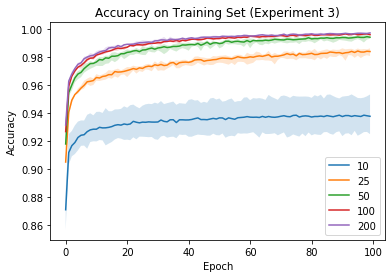

In [96]:
plt.plot(np.mean(train_10, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_10, axis=0), np.max(train_10, axis=0), alpha=0.2)

plt.plot(np.mean(train_25, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_25, axis=0), np.max(train_25, axis=0), alpha=0.2)

plt.plot(np.mean(train_50, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_50, axis=0), np.max(train_50, axis=0), alpha=0.2)

plt.plot(np.mean(train_100, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_100, axis=0), np.max(train_100, axis=0), alpha=0.2)

plt.plot(np.mean(train_200, axis=0))
plt.fill_between([x for x in range(100)], np.min(train_200, axis=0), np.max(train_200, axis=0), alpha=0.2)

plt.legend(['10', '25', '50', '100', '200'])
plt.title('Accuracy on Training Set (Experiment 3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('./results/experiment_3_training.png', dpi=400)

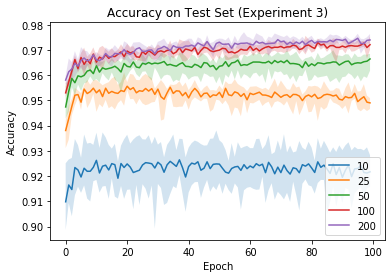

In [102]:
plt.plot(np.mean(test_10, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_10, axis=0), np.max(test_10, axis=0), alpha=0.2)

plt.plot(np.mean(test_25, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_25, axis=0), np.max(test_25, axis=0), alpha=0.2)

plt.plot(np.mean(test_50, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_50, axis=0), np.max(test_50, axis=0), alpha=0.2)

plt.plot(np.mean(test_100, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_100, axis=0), np.max(test_100, axis=0), alpha=0.2)

plt.plot(np.mean(test_200, axis=0))
plt.fill_between([x for x in range(100)], np.min(test_200, axis=0), np.max(test_200, axis=0), alpha=0.2)

plt.legend(['10', '25', '50', '100', '200'], loc=4)
plt.title('Accuracy on Test Set (Experiment 3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('./results/experiment_3_test.png', dpi=400)

## Experiment 4

In [349]:
nn = NN(input_length=X.shape[1], n_hidden_units=100, n_outputs=10, seed=new_seed)
adam = ADAM(layer_dims=nn.layer_dims, alpha=0.01, beta_m=0.99, beta_v=0.999, epsilon=0.00001)
mb_train = MiniBatcher(data=X_train, labels=y_train, batch_size=256, seed=new_seed)
mb_test = MiniBatcher(data=X_test, labels=y_test, batch_size=64, seed=new_seed)
train_profiler = ClassificationProfiler(classes=np.unique(y_train))
test_profiler = ClassificationProfiler(classes=np.unique(y_train))

EPOCHS = 100

train_loss_historical = list()
test_loss_historical = list()

epoch_counter = 0

while epoch_counter < EPOCHS:
    X_mb_train, y_mb_train = mb_train.fetch_minibatch()
    
    # If we've run out of training data in our training minibatcher, we can start on the testing loop
    # as well as incrementing our profiler
    if isinstance(X_mb_train, bool):
        X_mb_test, y_mb_test = mb_test.fetch_minibatch()
        train_profiler.update_stats()

        while not isinstance(X_mb_test, bool):
            fp_output_test = nn.forward_pass(input=X_mb_test)
            sm_output_test = nn.softmax(input=fp_output_test)
            test_loss = cross_entropy_loss(y_pred=sm_output_test, y_actual=y_mb_test)
            test_loss_historical.append(test_loss)
                        
            test_profiler.y_pred.append(np.argmax(sm_output_test, axis=1).tolist())
            test_profiler.y_actual.append(y_mb_test.tolist())
            
            X_mb_test, y_mb_test = mb_test.fetch_minibatch()
            
        # Here in the control-flow, we have exhausted our test-minibatcher 
        epoch_counter += 1
        mb_train.new_epoch()
        mb_test.new_epoch()
        
        test_profiler.update_stats()
        
        X_mb_train, y_mb_train = mb_train.fetch_minibatch()
    
    fp_output = nn.forward_pass(input=X_mb_train)
    sm_output = nn.softmax(input=fp_output)
    train_loss = cross_entropy_loss(y_pred=sm_output, y_actual=y_mb_train)
    train_loss_historical.append(train_loss)

    # It's important that we perform this append before the gradient is calculated
    # Something is accidentally mutable... 
    train_profiler.y_pred.append(np.argmax(sm_output, axis=1).tolist())
    train_profiler.y_actual.append(y_mb_train.tolist())
    
    grad = nn.get_gradient(input=X_mb_train, y_pred=sm_output, y_actual=y_mb_train)
    adam.update_weights(weights=nn.weights, gradient=grad)


209.11416292190552


In [278]:
train_profiler.info[99]

defaultdict(None,
            {'Overall': defaultdict(None, {'Accuracy': 0.9973833333333333}),
             'Class': defaultdict(None,
                         {'Precision': defaultdict(None,
                                      {0: 0.9984802431610942,
                                       1: 0.9992584902862227,
                                       2: 0.9973154362416108,
                                       3: 0.9973903115315609,
                                       4: 0.9948770491803278,
                                       5: 0.9976014760147601,
                                       6: 0.9984797297297298,
                                       7: 0.9984025559105432,
                                       8: 0.9967510259917921,
                                       9: 0.9949494949494949}),
                          'Recall': defaultdict(None,
                                      {0: 0.9983116663852777,
                                       1: 0.9994067042420647,
        

In [279]:
test_profiler.info[99]

defaultdict(None,
            {'Overall': defaultdict(None, {'Accuracy': 0.9754}),
             'Class': defaultdict(None,
                         {'Precision': defaultdict(None,
                                      {0: 0.9818181818181818,
                                       1: 0.9885462555066079,
                                       2: 0.9712368168744008,
                                       3: 0.9676470588235294,
                                       4: 0.9842602308499475,
                                       5: 0.960352422907489,
                                       6: 0.9893730074388948,
                                       7: 0.9776482021379981,
                                       8: 0.9830866807610994,
                                       9: 0.9497584541062802}),
                          'Recall': defaultdict(None,
                                      {0: 0.9918367346938776,
                                       1: 0.9885462555066079,
                     

In [158]:
# Saving the model
with open('./results/final_model.model', 'wb') as handle:
    pickle.dump(nn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [172]:
# Pulling out indexes where the 
class_idxs = defaultdict()

for c in np.unique(y_train):
    class_idxs[c] = [i for i, x in enumerate(y_train) if x == c]

In [178]:
W_0 = nn.weights[0]['W']
b_0 = nn.weights[0]['b']

class_activations = defaultdict()

for c in np.unique(y_train):
    idxs = class_idxs[c]
    Xs = X_train[idxs]
    
    class_activations[c] = np.maximum(0, np.dot(Xs, W_0) + b_0)

In [181]:
class_activations[0].shape

(5923, 100)

In [182]:
class_activations[0][0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  4.17975934,  0.        ,
       28.57245384,  0.        ,  0.        ,  0.        ,  5.62310578,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 19.50429471,  0.        ,  0.        ,  0.        ,
        0.        ,  5.14907845,  0.        ,  0.        ,  0.        ,
        0.        , 11.92734567,  0.        ,  0.        ,  0.05937997,
        0.        , 20.4675555 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  4.20437418,  0.        ,  0.        ,
        2.08035867,  0.        ,  0.        ,  0.        , 11.41532214,
        0.        ,  0.        , 14.47891674,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 16.29452751,  0.        , 22.74834158,  0.  

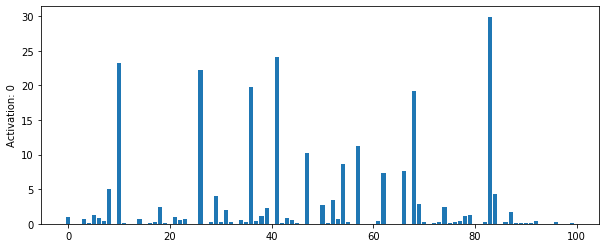

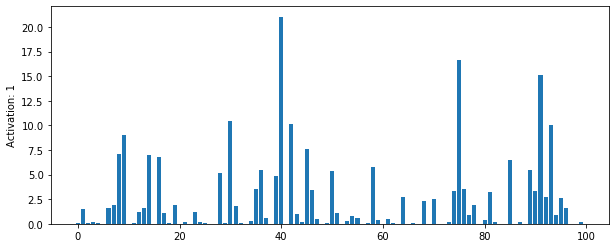

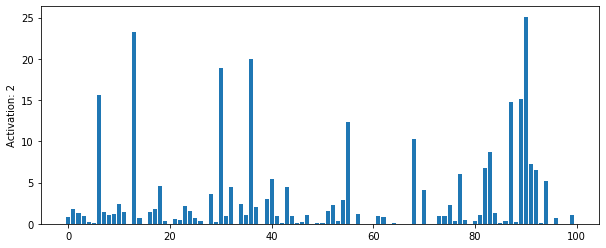

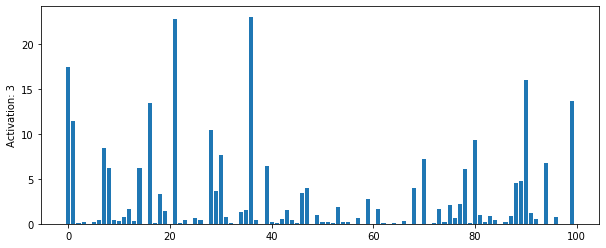

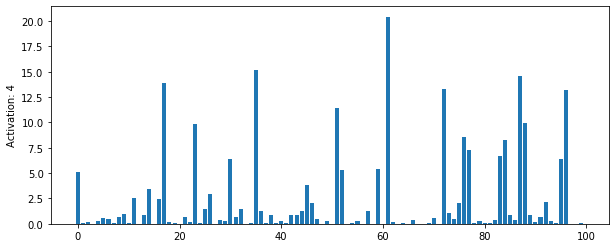

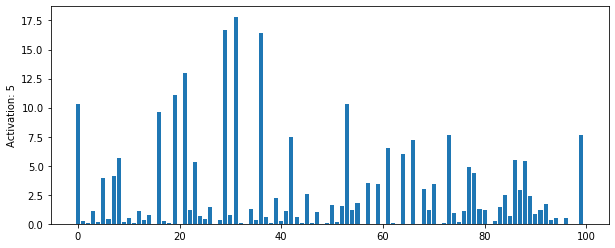

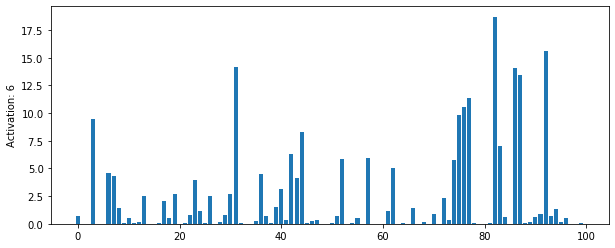

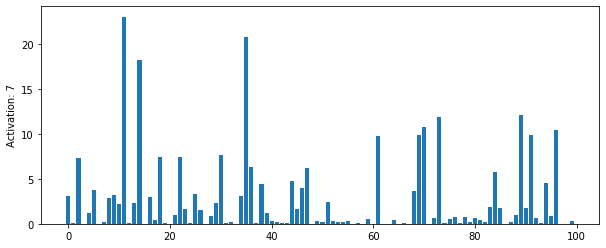

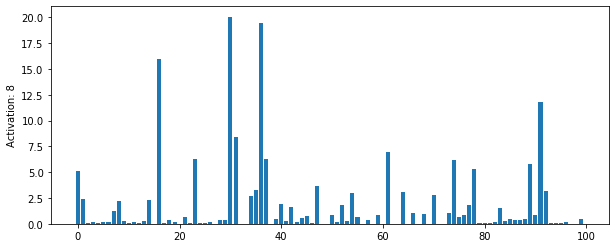

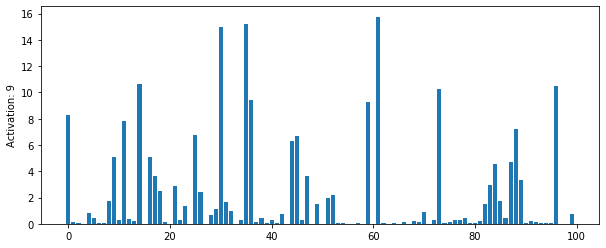

In [234]:

for c in list(class_activations.keys()):
    fig = plt.figure(figsize=(10,4))
    plt.bar([x for x in range(100)], np.mean(class_activations[c], axis=0))
    plt.ylabel(f'Activation: {c}')
    plt.savefig(f'./results/activation_{c}.png', dpi=400)

## Experiment 5

In [305]:
pixel_averages = np.mean(X_train[:, :], axis=0)

In [307]:
np.sum(pixel_averages == 0)

67

In [318]:
X_train_denoise = list()
X_test_denoise = list()

for example in X_train:
    X_train_denoise.append(example[np.array([pixel_averages[i] != 0 for i in range(pixel_averages.shape[0])])])

for example in X_test:
    X_test_denoise.append(example[np.array([pixel_averages[i] != 0 for i in range(pixel_averages.shape[0])])])

In [321]:
X_train_denoise = np.array(X_train_denoise)
X_test_denoise = np.array(X_test_denoise)

In [348]:
nn = NN(input_length=X_train_denoise.shape[1], n_hidden_units=100, n_outputs=10, seed=new_seed)
adam = ADAM(layer_dims=nn.layer_dims, alpha=0.01, beta_m=0.99, beta_v=0.999, epsilon=0.00001)
mb_train = MiniBatcher(data=X_train_denoise, labels=y_train, batch_size=256, seed=new_seed)
mb_test = MiniBatcher(data=X_test_denoise, labels=y_test, batch_size=64, seed=new_seed)
train_profiler_rf = ClassificationProfiler(classes=np.unique(y_train))
test_profiler_rf = ClassificationProfiler(classes=np.unique(y_train))

EPOCHS = 100

train_loss_historical_rf = list()
test_loss_historical_rf = list()

epoch_counter = 0

while epoch_counter < EPOCHS:
    X_mb_train, y_mb_train = mb_train.fetch_minibatch()
    
    # If we've run out of training data in our training minibatcher, we can start on the testing loop
    # as well as incrementing our profiler
    if isinstance(X_mb_train, bool):
        X_mb_test, y_mb_test = mb_test.fetch_minibatch()
        train_profiler_rf.update_stats()

        while not isinstance(X_mb_test, bool):
            fp_output_test = nn.forward_pass(input=X_mb_test)
            sm_output_test = nn.softmax(input=fp_output_test)
            test_loss = cross_entropy_loss(y_pred=sm_output_test, y_actual=y_mb_test)
            test_loss_historical_rf.append(test_loss)
                        
            test_profiler_rf.y_pred.append(np.argmax(sm_output_test, axis=1).tolist())
            test_profiler_rf.y_actual.append(y_mb_test.tolist())
            
            X_mb_test, y_mb_test = mb_test.fetch_minibatch()
            
        # Here in the control-flow, we have exhausted our test-minibatcher 
        epoch_counter += 1
        mb_train.new_epoch()
        mb_test.new_epoch()
        
        test_profiler_rf.update_stats()
        
        X_mb_train, y_mb_train = mb_train.fetch_minibatch()
    
    fp_output = nn.forward_pass(input=X_mb_train)
    sm_output = nn.softmax(input=fp_output)
    train_loss = cross_entropy_loss(y_pred=sm_output, y_actual=y_mb_train)
    train_loss_historical_rf.append(train_loss)

    # It's important that we perform this append before the gradient is calculated
    # Something is accidentally mutable... 
    train_profiler_rf.y_pred.append(np.argmax(sm_output, axis=1).tolist())
    train_profiler_rf.y_actual.append(y_mb_train.tolist())
    
    grad = nn.get_gradient(input=X_mb_train, y_pred=sm_output, y_actual=y_mb_train)
    adam.update_weights(weights=nn.weights, gradient=grad)


198.41649627685547


In [323]:
test_profiler_rf.info[99]

defaultdict(None,
            {'Overall': defaultdict(None, {'Accuracy': 0.9769}),
             'Class': defaultdict(None,
                         {'Precision': defaultdict(None,
                                      {0: 0.9857433808553971,
                                       1: 0.9911582670203359,
                                       2: 0.9748549323017408,
                                       3: 0.9713155291790306,
                                       4: 0.9825102880658436,
                                       5: 0.9774011299435028,
                                       6: 0.9811912225705329,
                                       7: 0.9803343166175025,
                                       8: 0.9646107178968655,
                                       9: 0.958904109589041}),
                          'Recall': defaultdict(None,
                                      {0: 0.9877551020408163,
                                       1: 0.9876651982378855,
                     

In [324]:
train_profiler_rf.info[99]

defaultdict(None,
            {'Overall': defaultdict(None, {'Accuracy': 0.99835}),
             'Class': defaultdict(None,
                         {'Precision': defaultdict(None,
                                      {0: 0.9993247805536799,
                                       1: 0.9988137603795967,
                                       2: 0.9988255033557047,
                                       3: 0.9983665468801045,
                                       4: 0.9988017802122561,
                                       5: 0.9968680913780398,
                                       6: 0.9991548343475322,
                                       7: 0.9979256422530717,
                                       8: 0.9976064284493076,
                                       9: 0.9976462676529926}),
                          'Recall': defaultdict(None,
                                      {0: 0.9994934999155833,
                                       1: 0.999110056363097,
                    

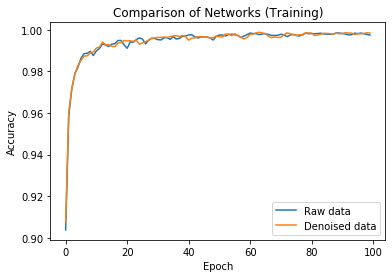

In [331]:
plt.plot([train_profiler.info[x]['Overall']['Accuracy'] for x in range(100)])
plt.plot([train_profiler_rf.info[x]['Overall']['Accuracy'] for x in range(100)])
plt.title('Comparison of Networks (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Raw data', 'Denoised data'])
plt.savefig('./results/nn_compare_train.png', dpi=400)

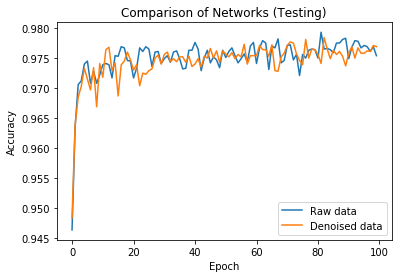

In [332]:
plt.plot([test_profiler.info[x]['Overall']['Accuracy'] for x in range(100)])
plt.plot([test_profiler_rf.info[x]['Overall']['Accuracy'] for x in range(100)])
plt.title('Comparison of Networks (Testing)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Raw data', 'Denoised data'])
plt.savefig('./results/nn_compare_test.png', dpi=400)

In [338]:
nn = NN(input_length=X.shape[1], n_hidden_units=100, n_outputs=10, seed=new_seed)
nn_weights = 0

for i in range(2):
    nn_weights += nn.weights[i]['W'].shape[0] *nn.weights[i]['W'].shape[1]
    nn_weights += nn.weights[i]['b'].shape[0] *nn.weights[i]['b'].shape[1]


In [339]:
nn_weights

79510

In [341]:
((nn_weights - 72810) / nn_weights) * 100

8.426613004653502

In [345]:
(784 - (784 - 67)) / 784

0.08545918367346939

In [343]:
X.shape

(70000, 784)

In [896]:
train_epoch_acc = list()
test_epoch_acc = list()

for e in range(EPOCHS):
    train_epoch_acc.append(train_profiler.info[e]['Overall']['Accuracy'])
    test_epoch_acc.append(test_profiler.info[e]['Overall']['Accuracy'])

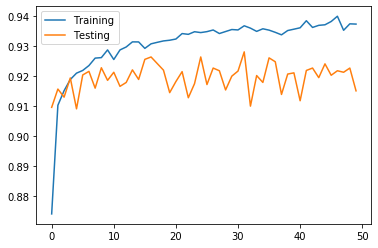

In [897]:
plt.plot(train_epoch_acc)
plt.plot(test_epoch_acc)
plt.legend(['Training', 'Testing'])